In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

# API permettant d'importer des données d'internet dans un dataframe
from pandas_datareader import data as pdr
import yfinance as yf

# yf.pdr_override()

2025-01-15 13:55:31.216503: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-15 13:55:31.231856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736945731.248743   56231 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736945731.253831   56231 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 13:55:31.274822: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# 1. Préparation des données

In [65]:
df = yf.download('AAPL', start="2012-01-01", end= datetime.now())
df.columns = df.columns.droplevel(1)  
df.info()

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3278 entries, 2012-01-03 to 2025-01-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3278 non-null   float64
 1   High    3278 non-null   float64
 2   Low     3278 non-null   float64
 3   Open    3278 non-null   float64
 4   Volume  3278 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 153.7 KB


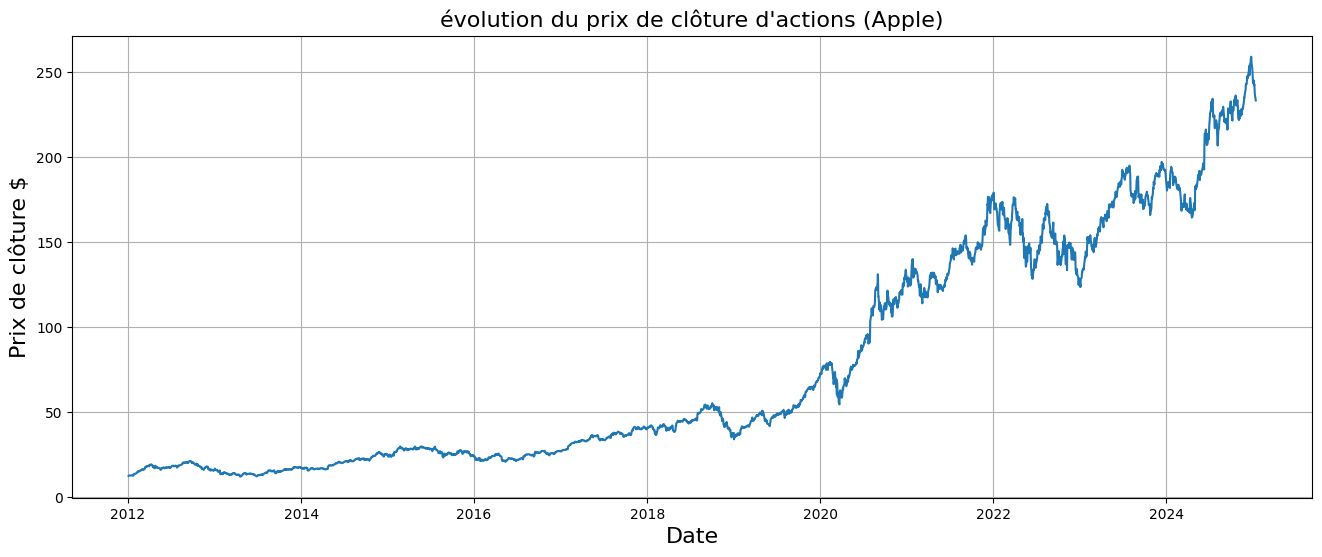

In [66]:
plt.figure(figsize=(16,6))
plt.title("évolution du prix de clôture d'actions (Apple)", fontsize=16)
plt.plot(df["Close"])
plt.xlabel("Date", fontsize=16)
plt.ylabel("Prix de clôture $", fontsize=16)
plt.grid(visible=True)
plt.show()

In [67]:
data = df["Close"]
dataset = np.array(data).reshape((-1,1))
train_data_len = int(np.ceil(len(dataset)*0.9))

In [68]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

In [69]:
# Train data
train_data = scaled_data[:train_data_len, :] # taking the 90% first values
x_train = []
y_train = []

# For each value of y, we take the 100 past values of y 
for i in range(100, len(train_data)):
    x_train.append(train_data[i-100:i, 0])
    y_train.append(train_data[i, 0])

# Test Data 
test_data = scaled_data[train_data_len-100:, :]
x_test = []
y_test = []
for i in range(100, len(test_data)):
    x_test.append(test_data[i-100:i, 0])
    y_test.append(test_data[i, 0])


x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

100

# 2. Mise en place du réseau récurrent

In [78]:
model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape = (x_train.shape[1],1 )))
model.add(LSTM(64, return_sequences = False))
model.add(Dense(25, activation = "linear"))
model.add(Dense(1, activation = "linear"))

model.compile(loss = "mse", optimizer = "adam", metrics = ["mae"])

In [79]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 100, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
es = EarlyStopping(monitor = "val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    x_train,
    y_train,
    validation_data = (x_test, y_test),
    batch_size = 1,
    epochs = 100,
    callbacks = [es]
)

Epoch 1/100


I0000 00:00:1736954666.618147   84916 cuda_dnn.cc:529] Loaded cuDNN version 90300


2851/2851 ━━━━━━━━━━━━━━━━━━━━ 177s 61ms/step - loss: 0.0021 - mae: 0.0229 - val_loss: 0.0011 - val_mae: 0.0284
Epoch 2/100
2851/2851 ━━━━━━━━━━━━━━━━━━━━ 167s 59ms/step - loss: 2.5139e-04 - mae: 0.0105 - val_loss: 0.0063 - val_mae: 0.0771
Epoch 3/100
2851/2851 ━━━━━━━━━━━━━━━━━━━━ 192s 67ms/step - loss: 2.9287e-04 - mae: 0.0110 - val_loss: 3.9277e-04 - val_mae: 0.0161
Epoch 4/100
2851/2851 ━━━━━━━━━━━━━━━━━━━━ 193s 68ms/step - loss: 2.0597e-04 - mae: 0.0092 - val_loss: 9.7899e-04 - val_mae: 0.0286
Epoch 5/100
2851/2851 ━━━━━━━━━━━━━━━━━━━━ 109s 38ms/step - loss: 2.0067e-04 - mae: 0.0093 - val_loss: 4.9538e-04 - val_mae: 0.0186
Epoch 6/100
2851/2851 ━━━━━━━━━━━━━━━━━━━━ 164s 58ms/step - loss: 1.7321e-04 - mae: 0.0083 - val_loss: 1.5949e-04 - val_mae: 0.0099
Epoch 7/100
2851/2851 ━━━━━━━━━━━━━━━━━━━━ 189s 66ms/step - loss: 1.2545e-04 - mae: 0.0078 - val_loss: 1.6752e-04 - val_mae: 0.0101
Epoch 8/100
2851/2851 ━━━━━━━━━━━━━━━━━━━━ 161s 56ms/step - loss: 1.7356e-04 - mae: 0.0089 - val_los

# 3. Prédictions et visualisations 

In [84]:
pred = model.predict(x_test)
y_pred = scaler.inverse_transform(pred)
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


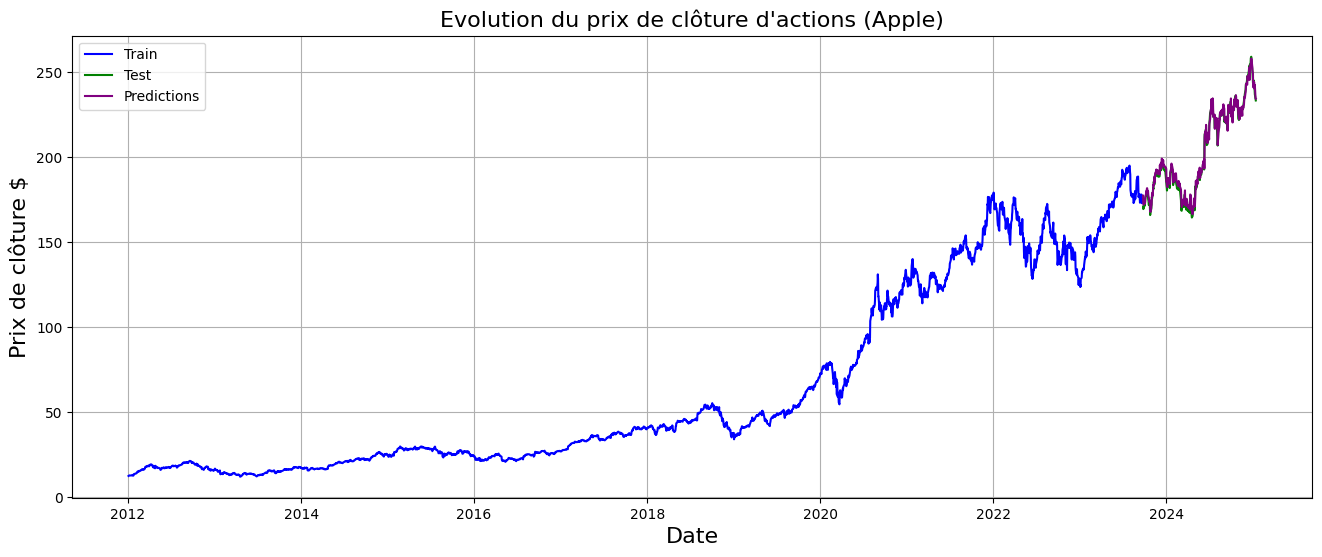

In [85]:
plt.figure(figsize = (16,6))
plt.title("Evolution du prix de clôture d'actions (Apple)", fontsize=16)
plt.plot(df['Close'].iloc[:train_data_len], color = "blue")
plt.plot(df.index[train_data_len:], y_true, color = "green")
plt.plot(df.index[train_data_len:], y_pred, color = "purple")
plt.xlabel('Date', fontsize=16)
plt.ylabel('Prix de clôture $', fontsize=16)
plt.legend(["Train", "Test", "Predictions"])
plt.grid(visible=True)
plt.show()